In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

Optimal alpha: 14.563484775012444
Train MSE: 2.508
Test MSE: 2.583


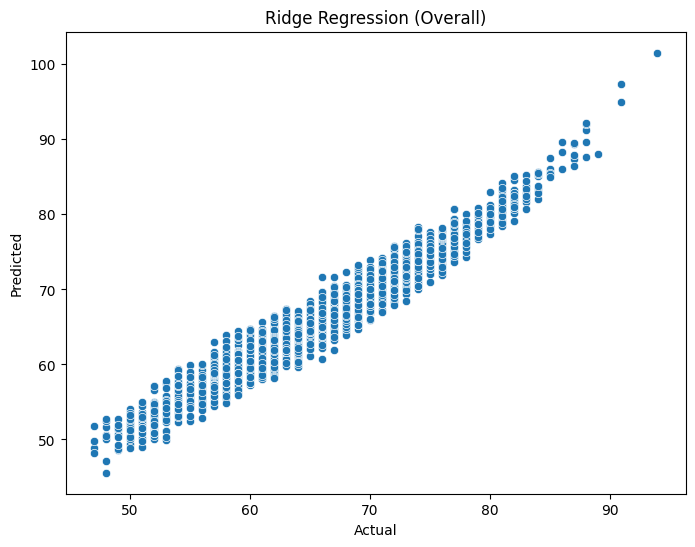

In [22]:
# Load the dataset
data = pd.read_csv('../datasets/cleaned.csv')

# Choose target
target_col = 'Overall'  # or 'Value' or 'Wage'
y = data[target_col]

# Drop rows with missing target to avoid leakage or invalid labels
mask = y.notna()
data = data[mask].copy()
y = y[mask]

# Drop ID/name/date-like fields and the target from features
drop_cols = ['ID', 'Name', 'Joined', 'Contract Valid Until', target_col]
X = data.drop(columns=[c for c in drop_cols if c in data.columns])

# Identify columns by type
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.columns.difference(categorical_cols)

# Transformers with imputation
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # use sparse_output=False if on newer sklearn
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ],
    remainder='drop'
)

# Ridge + hyperparameter tuning
alphas = np.logspace(-3, 3, 50)
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('ridge', Ridge())
])
param_grid = {'ridge__alpha': alphas}

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Cross-validated search
grid = GridSearchCV(
    model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print(f"Optimal alpha: {grid.best_params_['ridge__alpha']}")

# Evaluate
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Ridge Regression ({target_col})")
plt.show()